# Speech acts in the WILD

Analysis of the presence of speech acts inside the dataset WildChat, a collection of conversations between human and ChatGPT.

In [2]:
import pandas as pd

#wildchat_auto_eval = pd.read_csv('wildchat_speechacts.csv')
wildchat_human_eval = pd.read_csv('human_eval_df.csv')

We sampled 1000 examples from the conversations with GPT-4 and automatically analyzed them with GPT-4. Then, we took a subsample of 100 examples and performed manual evaluation on it. Here are some examples:

|    id | speech_act | force | sentence                                          |
|-------|------------|-------|---------------------------------------------------|
|  5970 | DEC        | QUE   | I would like to have the map of Europe.           |
|  6657 | DEC        | REQ   | For this conversation, I want you to be RPGGPT.   |
|  8970 | DEC        | THR   | import pandas as pd\n\n# Start writing code\ns... |
|  5459 | INT        | QUE   | Please invent and describe an algorithm that e... |
|  2409 | INT        | REQ   | Come up with a scene in which a group of Chris... |
|  2409 | INT        | THR   | Come up with a scene in which a group of Chris... |
|  2409 | IMP        | REQ   | Rewrite it to a humanlike explanation.            |
|  2409 | IMP        | THR   | Come up with a scene in which a group of Chris... |


In [ ]:
speech_acts = wildchat_human_eval['speech_act'].unique()
print(speech_acts)


In [ ]:
filter_df = wildchat_human_eval.loc[wildchat_human_eval['label'] == 'IMP']
for id_, sent in zip(filter_df['id'], filter_df['sentence']):
    print(f"\n### {id_} ###\n", sent)

## Human Eval

In [25]:
auto_label = wildchat_human_eval['speech_act']
human_label = wildchat_human_eval['label']

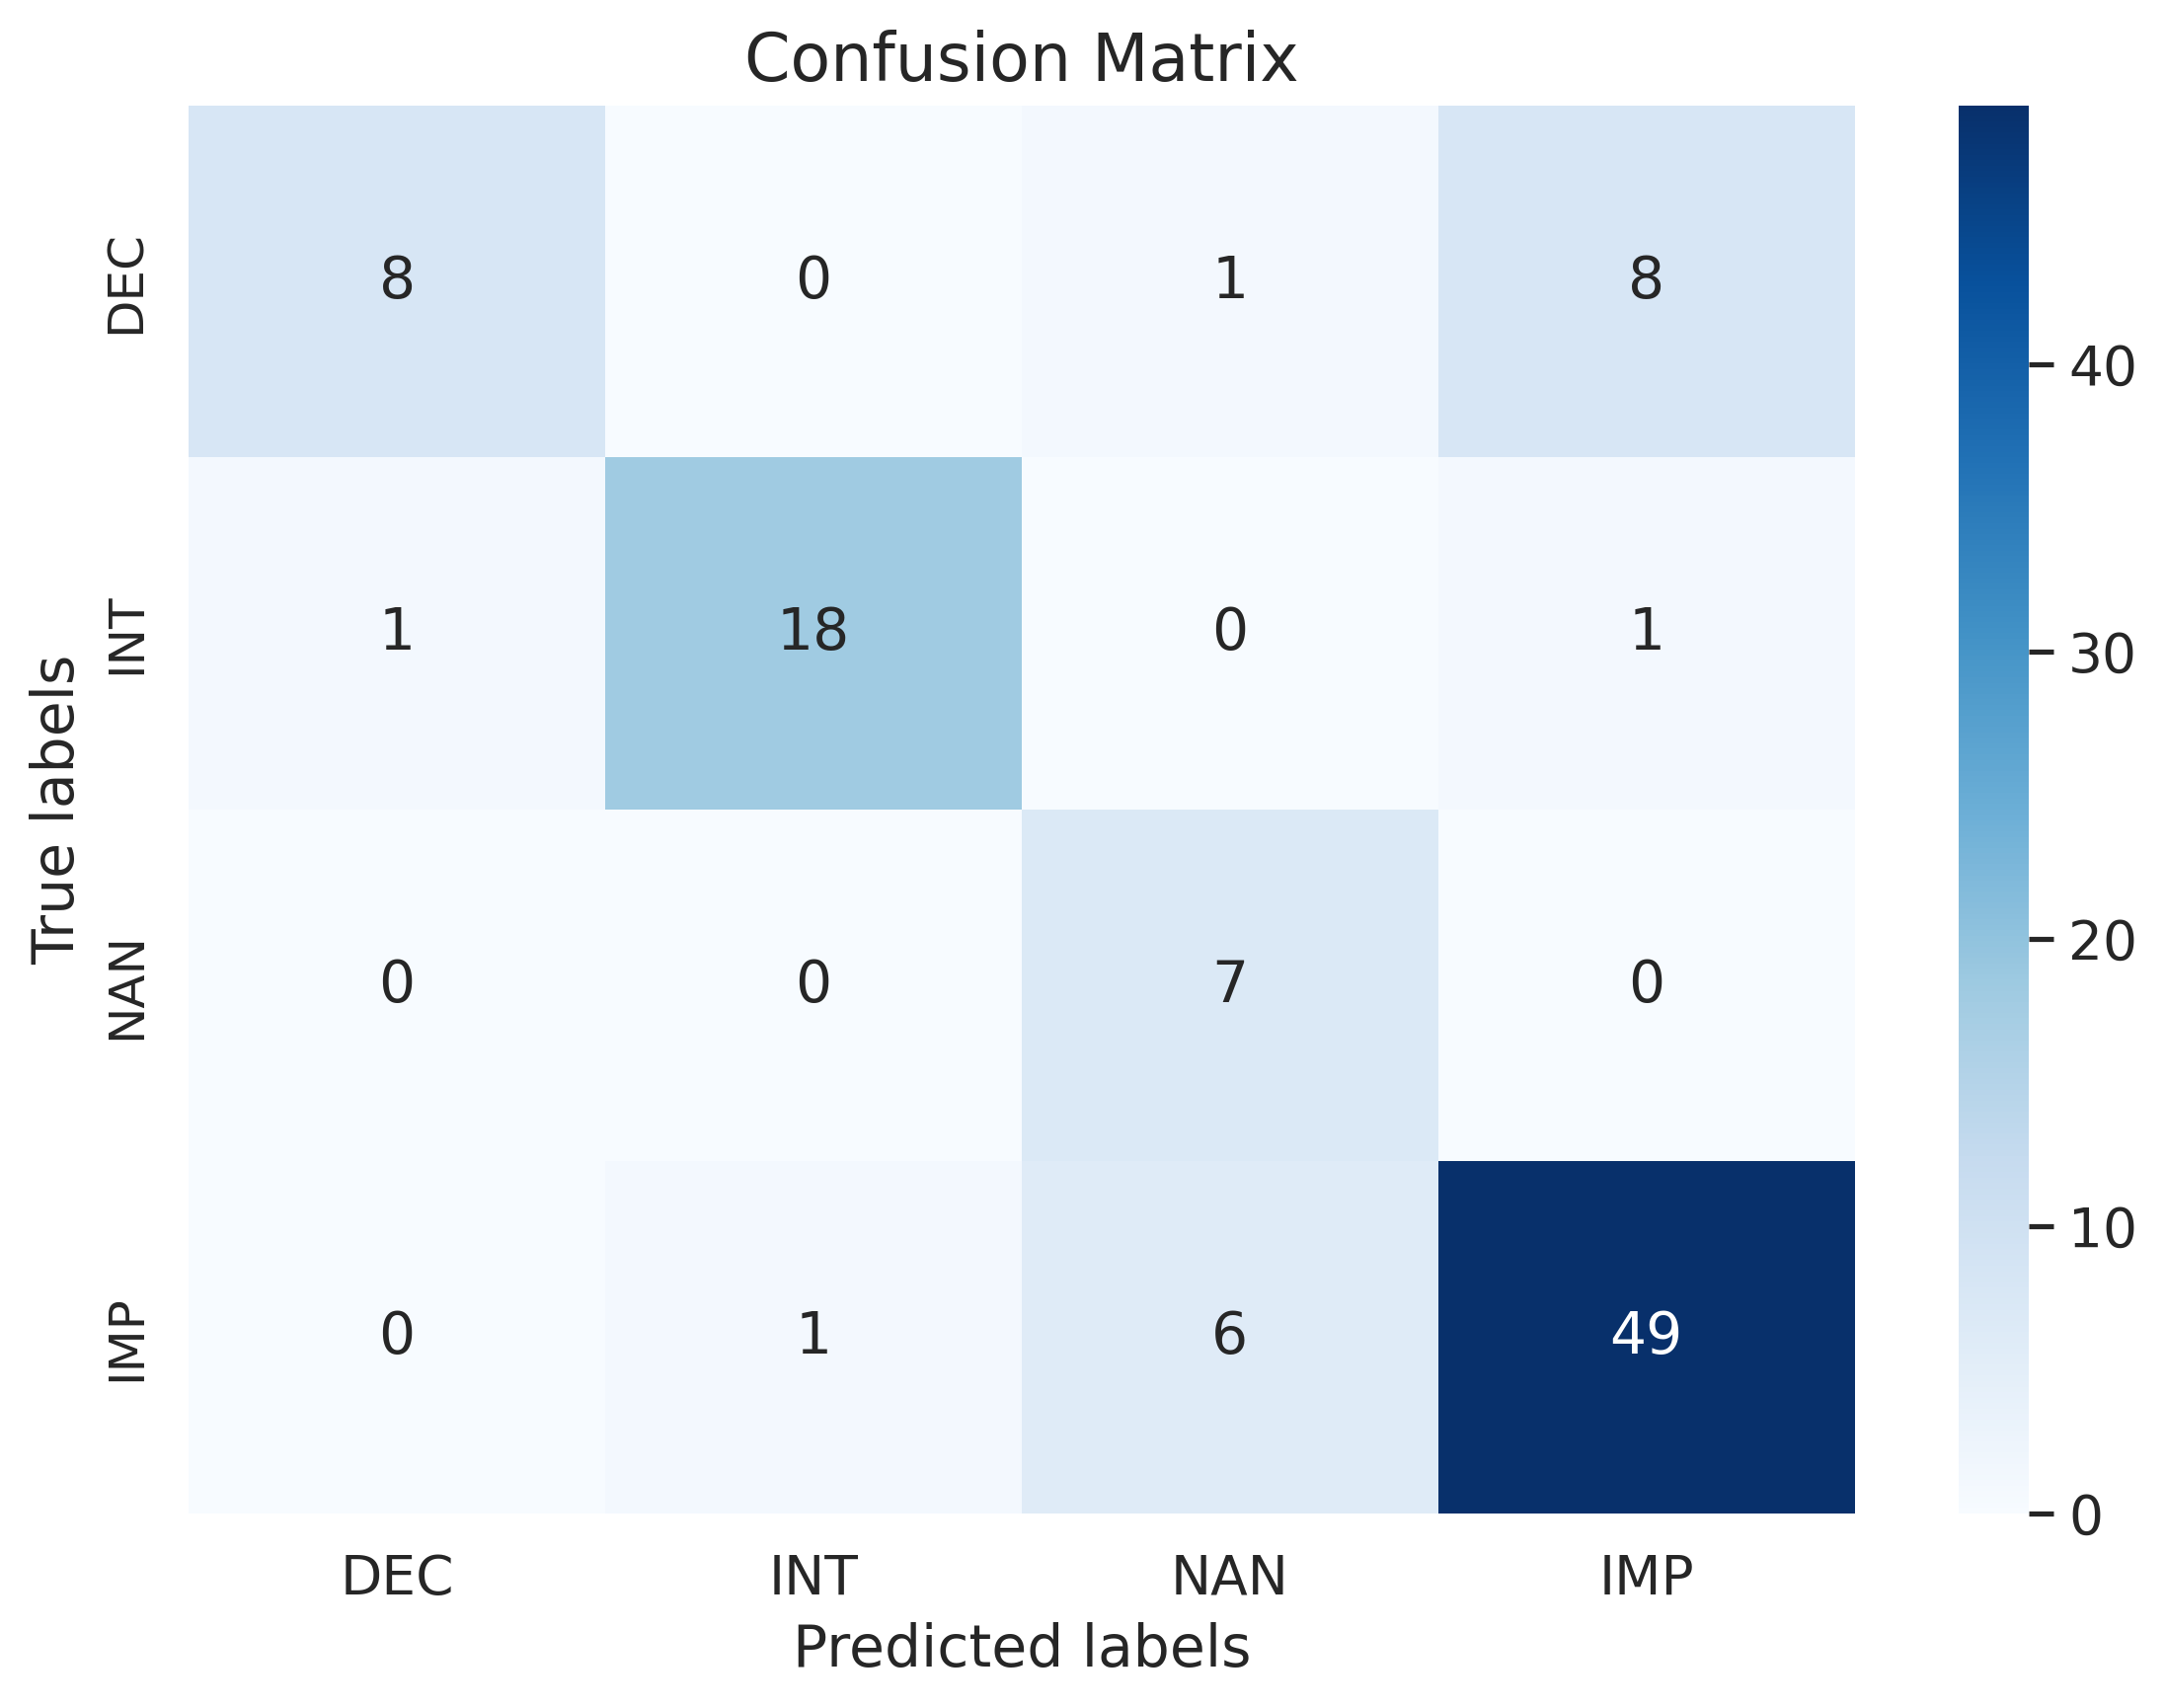

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_mapping = {'DEC': 0, 'INT': 1, 'NAN': 2, 'IMP': 3}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

auto_label_mapped = auto_label.map(label_mapping)
human_label_mapped = human_label.map(label_mapping)

cm = confusion_matrix(human_label_mapped, auto_label_mapped)

# Setting up figure size and DPI
plt.figure(figsize=(8, 6), dpi=300)  # Adjust size and DPI as needed

# Creating the heatmap
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', cmap='Blues',
                 xticklabels=label_mapping.keys(),
                 yticklabels=label_mapping.keys())

# Customizing ticks for readability
#plt.xticks(rotation=45, ha="right", fontsize=12)  # Adjust fontsize as needed
plt.yticks(fontsize=12)  # Adjust fontsize as needed

# Labels and title with custom font sizes
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Tight layout often improves the spacing between subplots
plt.tight_layout()

# Save the figure if you like
plt.savefig('confusion_matrix.png', format='png', dpi=300)  # Saves the figure with high resolution

plt.show()


In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming labels are from 0 to 3 for 4 classes
num_classes = 4

# Initialize dictionaries to store metrics for each class
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}

for class_id in range(num_classes):
    true_binary = (human_label_mapped.values == class_id).astype(int)
    pred_binary = (auto_label_mapped.values == class_id).astype(int)

    # Compute metrics
    accuracy = accuracy_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)

    # Store metrics in dictionaries
    accuracies[class_id] = accuracy
    precisions[class_id] = precision
    recalls[class_id] = recall
    f1_scores[class_id] = f1

# Initialize a list to store the data for DataFrame creation
data_for_df = []

for class_id in range(num_classes):
    data_for_df.append({
        'Class': inverse_label_mapping[class_id],
        'Accuracy': accuracies[class_id],
        'Precision': precisions[class_id],
        'Recall': recalls[class_id],
        'F1-Score': f1_scores[class_id]
    })

# Create the DataFrame
metrics_df = pd.DataFrame(data_for_df)

# Set the class as the index
metrics_df.set_index('Class', inplace=True)

# Print the DataFrame
display(metrics_df)

,Accuracy,Precision,Recall,F1-Score
Class,,,,
DEC,0.90,0.888889,0.470588,0.615385
INT,0.97,0.947368,0.900000,0.923077
NAN,0.93,0.500000,1.000000,0.666667
IMP,0.84,0.844828,0.875000,0.859649


## Auto Eval

Results from human eval are conservative, so they tend to classify more prompt as not speech acts than as such. We can then proceed to obtain the results from the auto eval done by GPT-4.

In [52]:
# Correct mislabeled speech acts with NAN
wildchat_auto_eval['speech_act'] = wildchat_auto_eval['speech_act'].apply(lambda x: x if x in ['DEC', 'INT', 'NAN', 'IMP'] else 'NAN')

In [53]:
wildchat_auto_eval['speech_act'].value_counts() / 10

speech_act
IMP    46.9
INT    23.7
DEC    17.1
NAN    12.3
Name: count, dtype: float64

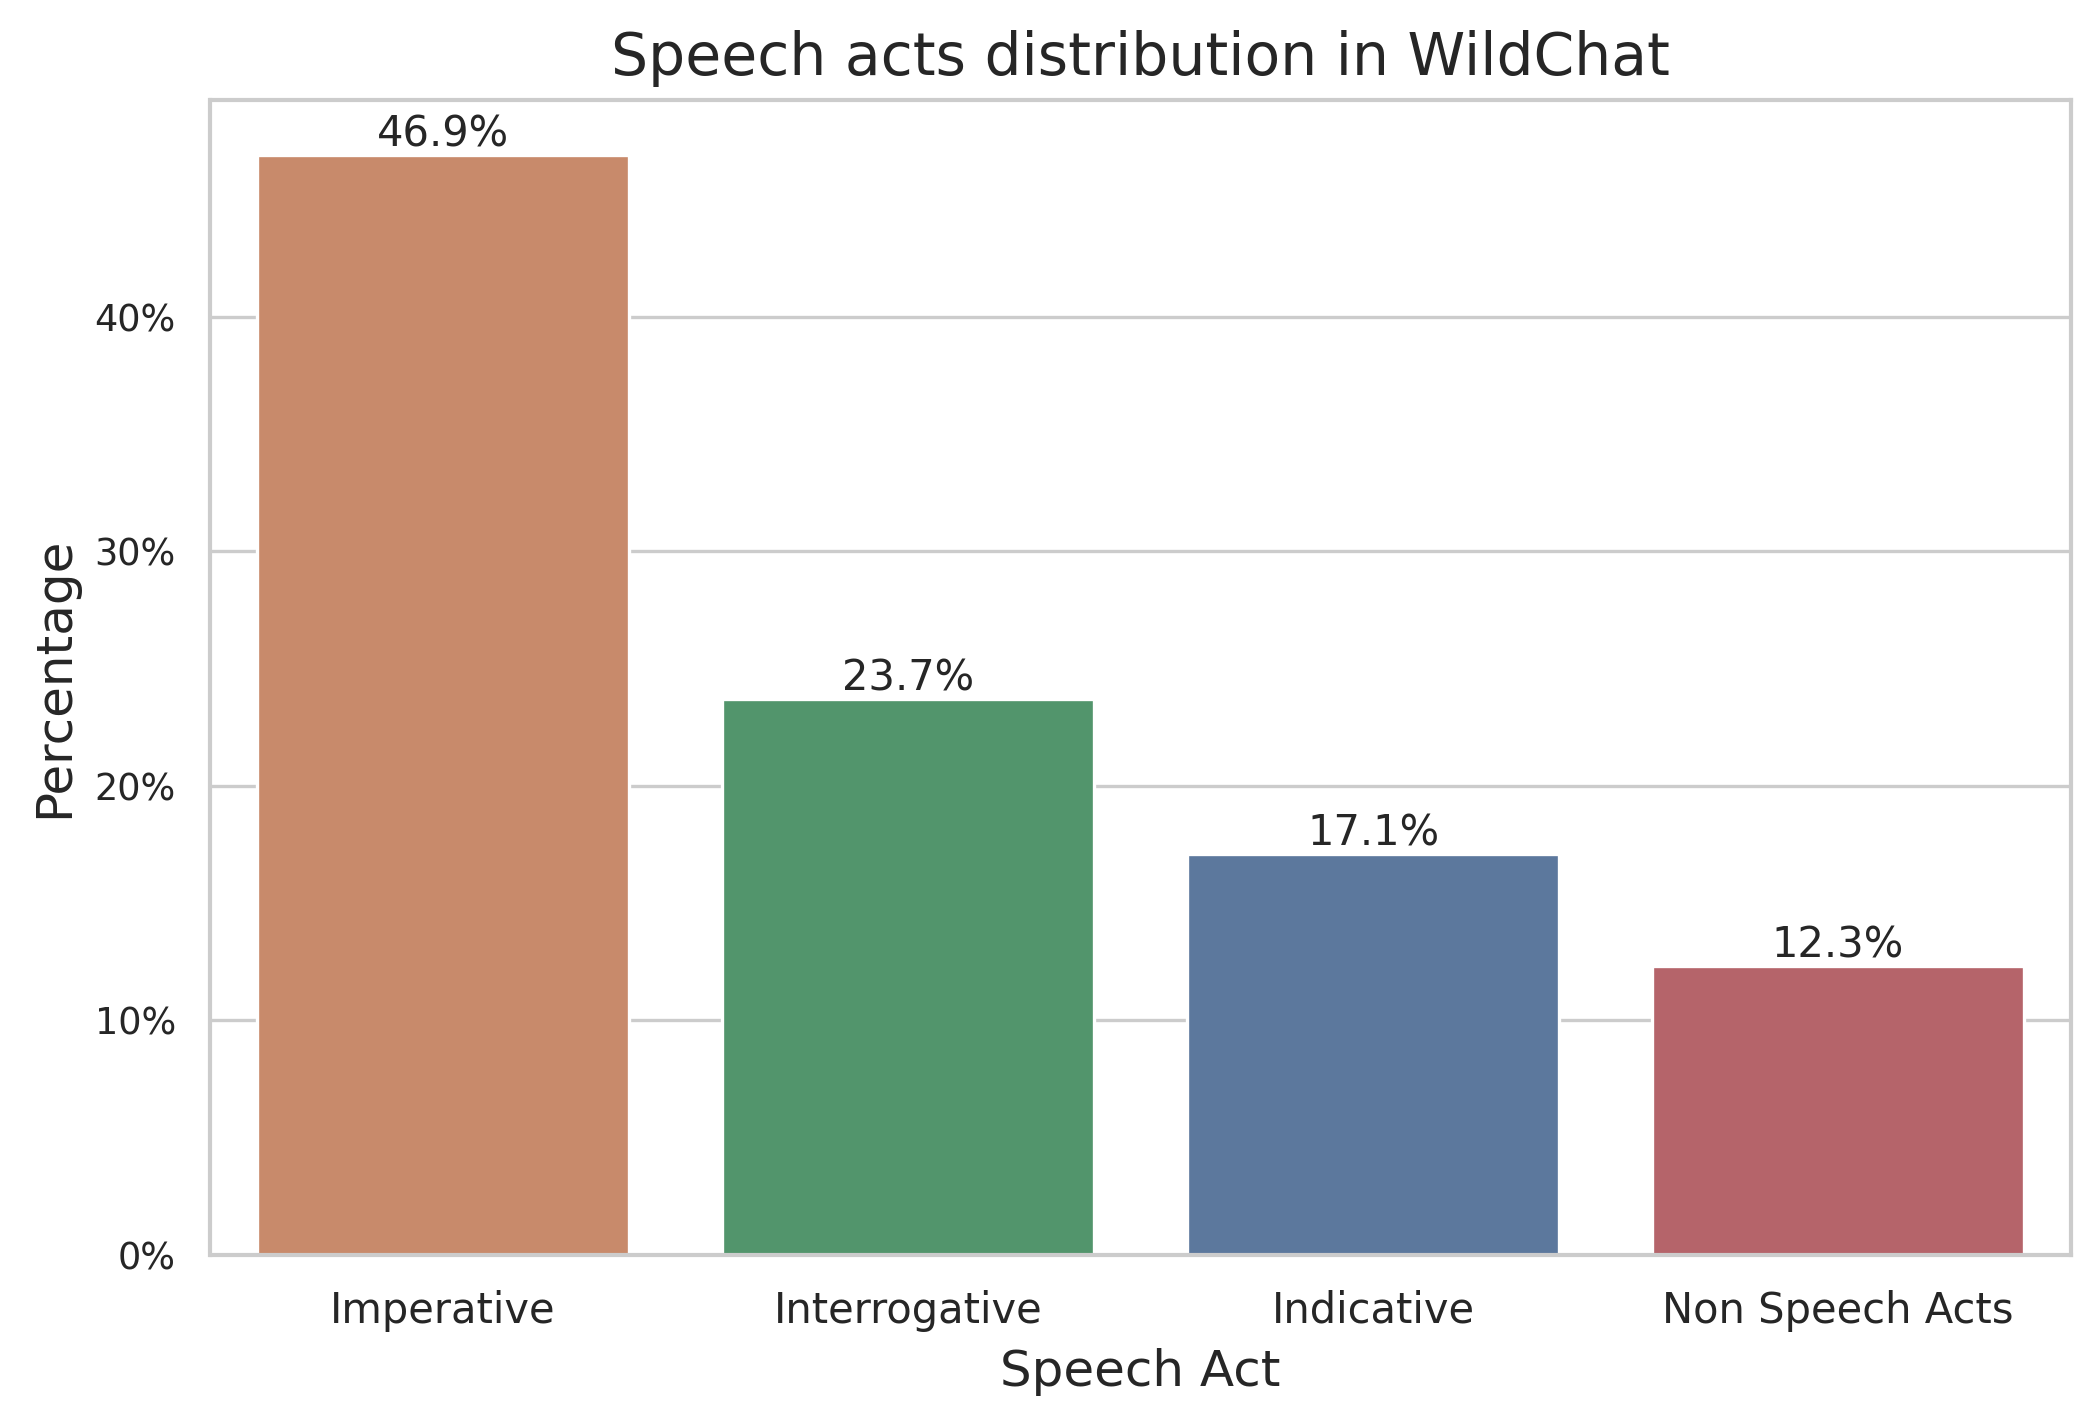

In [83]:
import matplotlib.ticker as ticker

# Convert the Series to a DataFrame
df = (wildchat_auto_eval['speech_act'].value_counts() / 1000).reset_index()
df.columns = ['Speech Act', 'Percentage']

# Set the seaborn theme for aesthetics
sns.set_theme(context='paper', style='whitegrid')
plt.figure(figsize=(8, 5), dpi=300)

# Plotting
palette = sns.color_palette(['#d8855b', '#47a069', '#5176a8', '#c2575e'])
ax = sns.barplot(x='Speech Act', y='Percentage', data=df, hue='Speech Act', palette=palette)


plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Speech Act', fontsize=12)
plt.xticks(ticks=ax.get_xticks(), labels=['Imperative', 'Interrogative', 'Indicative', 'Non Speech Acts'], fontsize=10) 

plt.title('Speech acts distribution in WildChat', fontsize=14)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height() * 100:.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, 
                xytext=(0, 5), textcoords='offset points')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.show()